In [1]:
import importlib
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from DiscEvolution.constants import Msun, AU, yr, k_B, m_p,GasConst, Omega0
from DiscEvolution.grid import Grid, MultiResolutionGrid
from DiscEvolution.star import SimpleStar, MesaStar
from DiscEvolution.eos  import IrradiatedEOS, LocallyIsothermalEOS, SimpleDiscEOS
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.dust import DustGrowthTwoPop
from DiscEvolution.opacity import Tazzari2016, Zhu2012
from DiscEvolution.viscous_evolution import ViscousEvolutionFV,ViscousEvolution,LBP_Solution
from DiscEvolution.dust import SingleFluidDrift
from DiscEvolution.diffusion import TracerDiffusion
from DiscEvolution.driver import DiscEvolutionDriver
from DiscEvolution.io import Event_Controller, DiscReader
from DiscEvolution.disc_utils import mkdir_p
from DiscEvolution.planet import Planet, PlanetList

In [3]:
# Try a general setup with Disc Winds
from DiscEvolution.viscous_evolution import TaboneSolution

In [19]:
def plotstuff(R,eos,disc,Mdot_visc,Mdot_DW,Mdot_total):
    fig,ax=plt.subplots()
    plt.loglog(R,eos.nu)
    ax.set_ylabel(r'$\nu$ (code units)')
    ax.set_xlabel('Distance (AU)')
    fig,ax=plt.subplots()
    plt.loglog(R,eos.T)
    ax.set_ylabel('T (K)')
    ax.set_xlabel('Distance (AU)')
    fig,ax=plt.subplots()
    plt.loglog(R,disc.Sigma)
    ax.set_ylabel(r'$\Sigma (g/cm^2)$')
    ax.set_xlabel('Distance (AU)')
    fig,ax=plt.subplots()
    plt.loglog(R,eos.cs*AU*yr/3.15e7)
    ax.set_ylabel(r'$c_s (cm/s)$')
    ax.set_xlabel('Distance (AU)')
    fig,ax=plt.subplots()
    plt.loglog(R,Mdot_visc,label='Visc')
    plt.loglog(R,Mdot_DW,label='DW')
    plt.loglog(R,Mdot_total,label='Total')
    plt.legend()
    ax.set_ylabel(r'$\dot{M} (M_\odot/yr)$')
    ax.set_xlabel('Distance (AU)')

5.085113229906012e-10 9.578092441111253e-11 6.042922474017137e-10
0.05994692728127657
Iterating Case 1
28053.402411156232 24.593235746957852 2.5173227568969e-09 0.05978914125017287
56410.16638901913 12.360885717510188 5.041315349037171e-09 0.05957417107455711
79468.47587907477 8.807814198853814 7.078531449103287e-09 0.05939838317062224
94109.92563217833 7.447800603301569 8.365032410848248e-09 0.059286334143621514
102337.80056107817 6.852675730629101 9.08557053109847e-09 0.05922322498333366
106691.15201068272 6.57454772321452 9.466099560653719e-09 0.05918979303416243
108926.82653948719 6.440263410345721 9.661331025356407e-09 0.05917261298699371
110058.08854569015 6.374371391620501 9.76006987615346e-09 0.059163916966030454
110626.31161158267 6.34177737870449 9.809653062731821e-09 0.059159548312277606
110910.67998932528 6.325589675903516 9.834463934640337e-09 0.059157361830512525


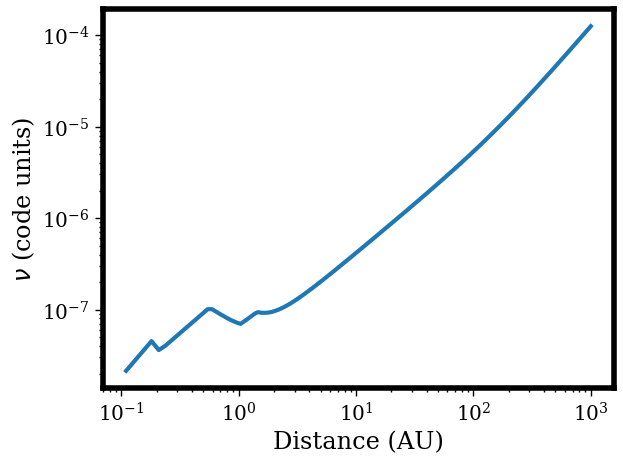

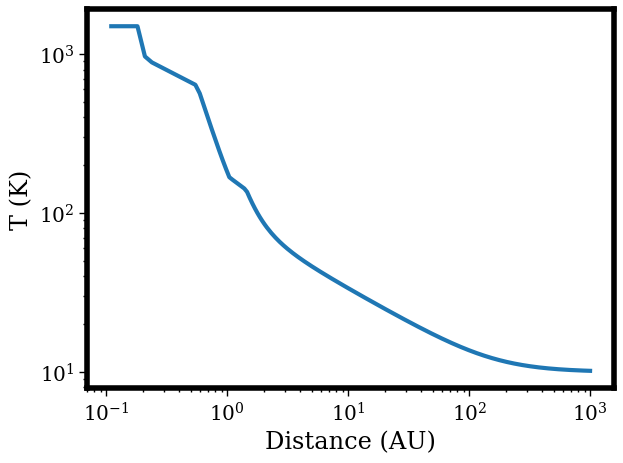

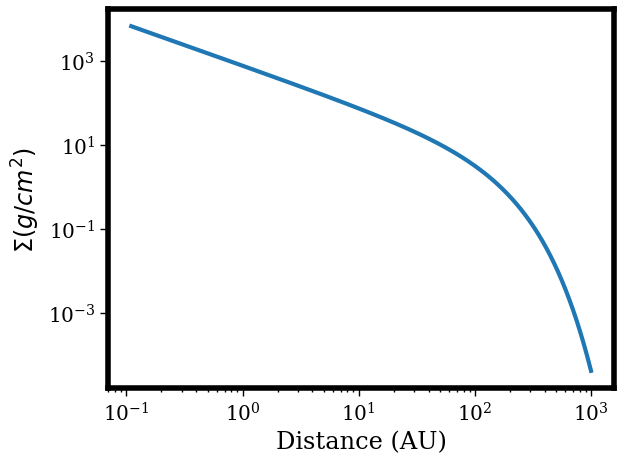

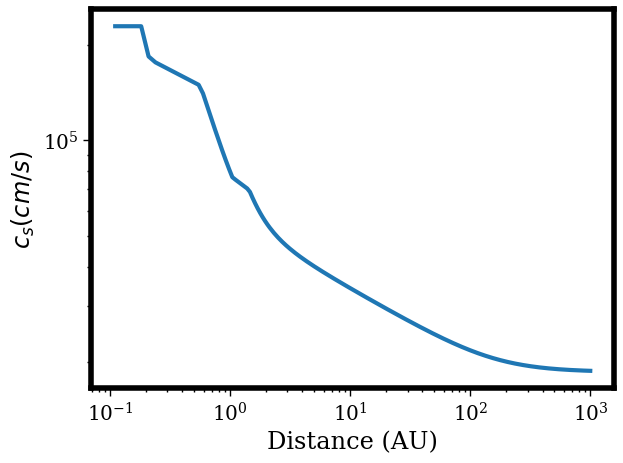

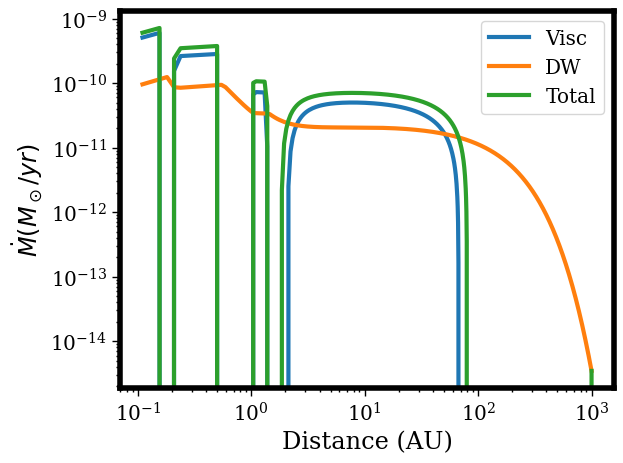

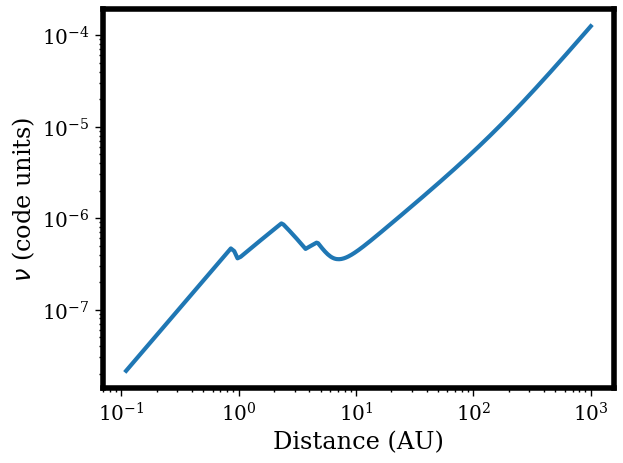

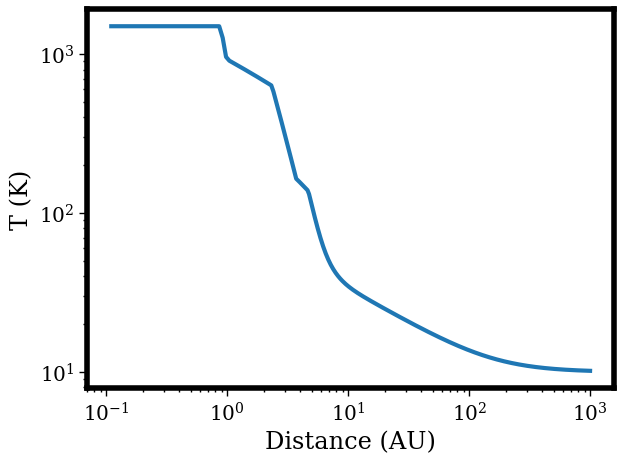

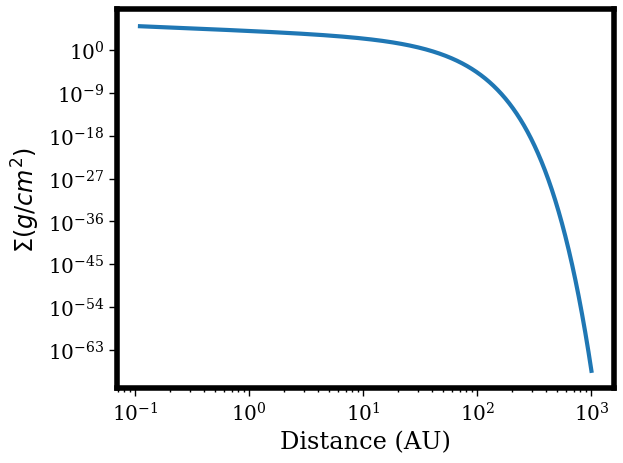

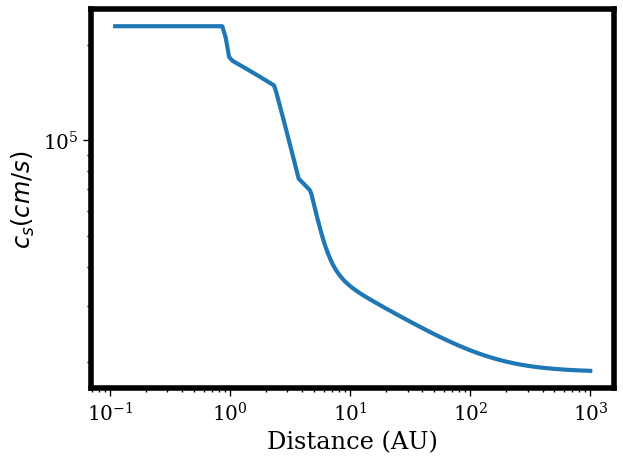

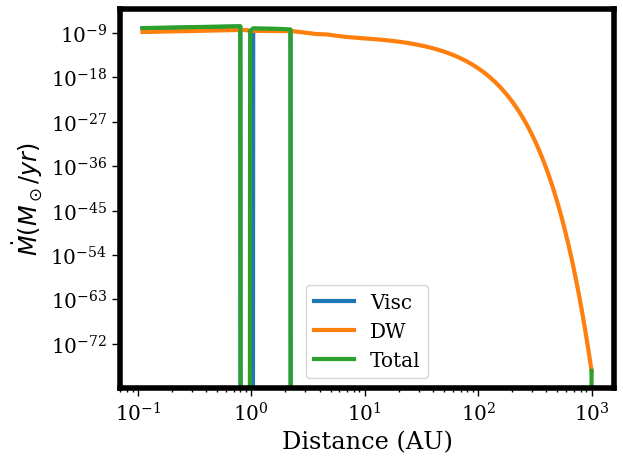

In [23]:
Mdisk0 = 0.06
Mdisk = Mdisk0 * Msun # g
Mdot0 = 1.e-8
Mdot = Mdot0 * Msun/yr # g
Rd=100. # AU.  Exponential cutoff of disk.
gamma=1.
mu=2.33
psi=0.1
# initial guesses
alpha_SS=1.e-4 # initial guess
grid = Grid(0.1, 1000, 1000, spacing='natural')
R = grid.Rc
star = SimpleStar()
viscous = ViscousEvolutionFV()

# Need initial value of nud to get Sigma solution.  Not used at t=0 though
nud=1.
sol=TaboneSolution(Mdisk/(AU*AU),Rd,nud,psi)
Sigma = sol(grid.Rc, 0.)
Om_invsecond=star.Omega_k(R)*yr/3.15e7


eos = IrradiatedEOS(star, alpha_SS)
eos.set_grid(grid)    
eos.update(0,Sigma)
nud = np.interp(Rd, grid.Rc, eos.nu)
eos_cgs=eos.cs*AU*yr/3.15e7

disc = AccretionDisc(grid, star, eos, Sigma)

vr_visc=viscous.viscous_velocity(disc,S=Sigma)
Mdot_visc=np.append(disc.Mdot(vr_visc),0)
Mdot_DW=3.*np.pi/(Om_invsecond)*Sigma*eos_cgs*eos_cgs*psi*alpha_SS/Msun*3.15e7
Mdot_total=Mdot_visc+Mdot_DW

print (Mdot_visc[0],Mdot_DW[0],Mdot_total[0])
print (disc.Mtot()/Msun)
plotstuff(R,eos,disc,Mdot_visc,Mdot_DW,Mdot_total)

Case = 1
# Now iterate
# Case 1:  Given Mdisk, Mdot, alpha and psi.  Solve for Sigma (Sigma_0 and rd)
if (Case==1):
    print ('Iterating Case 1')
    for i in range(10):
        # Mdot is proportional to Sigma0.  So scale Sigma
        Sigma=Sigma*Mdot0/Mdot_total[0]
        disc = AccretionDisc(grid, star, eos, Sigma)
        # M is proportional to rc^2.
        Rd=Rd*np.sqrt(Mdisk0/(disc.Mtot()/Msun))
        sol=TaboneSolution(Mdisk/(AU*AU),Rd,nud,psi)
        Sigma = sol(grid.Rc, 0.)
        disc = AccretionDisc(grid, star, eos, Sigma)        
        eos.update(0,Sigma)
        eos_cgs=eos.cs*AU*yr/3.15e7
        vr_visc=viscous.viscous_velocity(disc,S=Sigma)
        Mdot_visc=np.append(disc.Mdot(vr_visc),0)
        Mdot_DW=3.*np.pi/(Om_invsecond)*Sigma*eos_cgs*eos_cgs*psi*alpha_SS/Msun*3.15e7
        Mdot_total=Mdot_visc+Mdot_DW
        print (Sigma[0],Rd,Mdot_total[0],disc.Mtot()/Msun)

    plotstuff(R,eos,disc,Mdot_visc,Mdot_DW,Mdot_total)    

# Case 2:  Given Mdisk, Mdot, Rd and psi.  Solve for Sigma0 and alpha.
if (Case==2):
    print ('Iterating Case 2')
    for i in range(10):
        # Sigma0 is fully determined by Mdisk and Rd so no need to iterate.
        # Mdot is approximately proportional to alpha.  So scale alpha
        alpha_SS=alpha_SS*(Mdot0/Mdot_total[0])
        eos = IrradiatedEOS(star, alpha_SS)
        eos.set_grid(grid)    
        eos.update(0,Sigma)
        disc = AccretionDisc(grid, star, eos, Sigma)
        eos_cgs=eos.cs*AU*yr/3.15e7
        vr_visc=viscous.viscous_velocity(disc,S=Sigma)
        Mdot_visc=np.append(disc.Mdot(vr_visc),0)
        Mdot_DW=3.*np.pi/(Om_invsecond)*Sigma*eos_cgs*eos_cgs*psi*alpha_SS/Msun*3.15e7
        Mdot_total=Mdot_visc+Mdot_DW
        print (Sigma[0],Rd,Mdot_total[0],disc.Mtot()/Msun)
    plotstuff(R,eos,disc,Mdot_visc,Mdot_DW,Mdot_total)  